In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

[*********************100%***********************]  5 of 5 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_82189/3041180626.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df['Close'].resample('M').last()


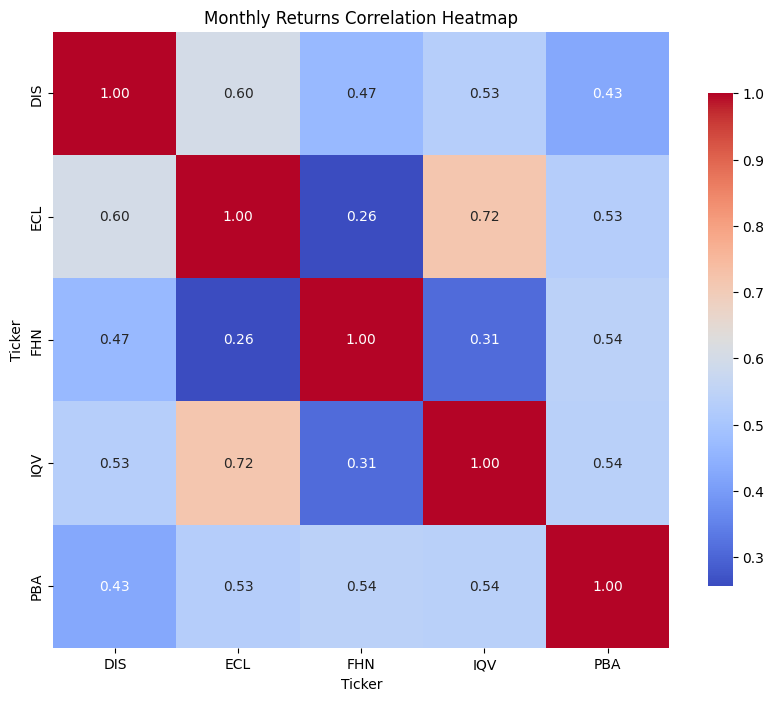

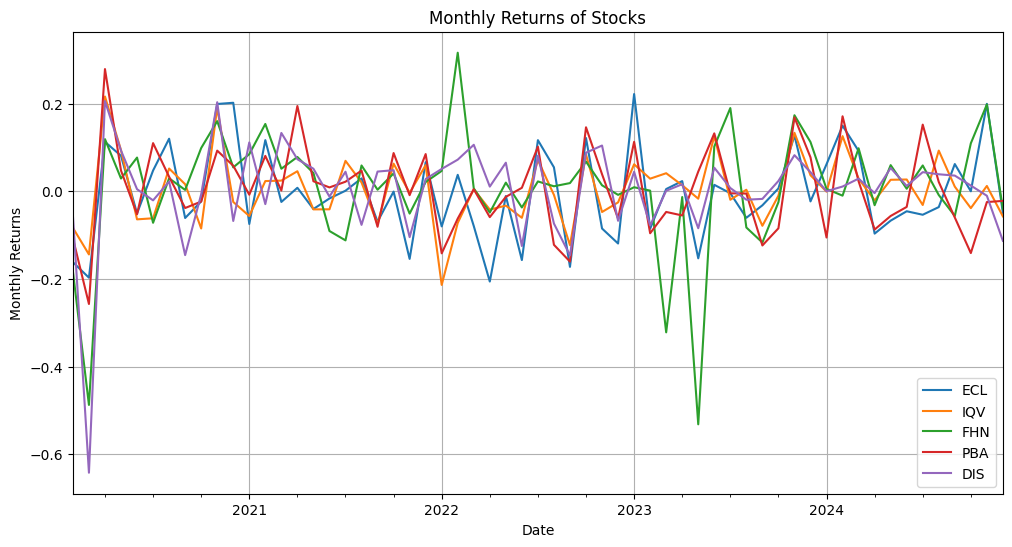

In [5]:
#import all 4 stocks 

stocks = ['ECL','IQV', 'FHN', 'PBA', 'DIS']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')
# Resample to monthly frequency
df = df['Close'].resample('M').last()
# Calculate monthly returns
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
#plot the heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(monthly_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Monthly Returns Correlation Heatmap')
plt.show()

#plot the returns of each stock
log_returns.plot(figsize=(12, 6))
plt.title('Monthly Returns of Stocks')
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.legend(stocks)
plt.grid()
plt.show()

[*********************100%***********************]  5 of 5 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_82189/1540500209.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').last()


Mean Squared Error: 0.0144


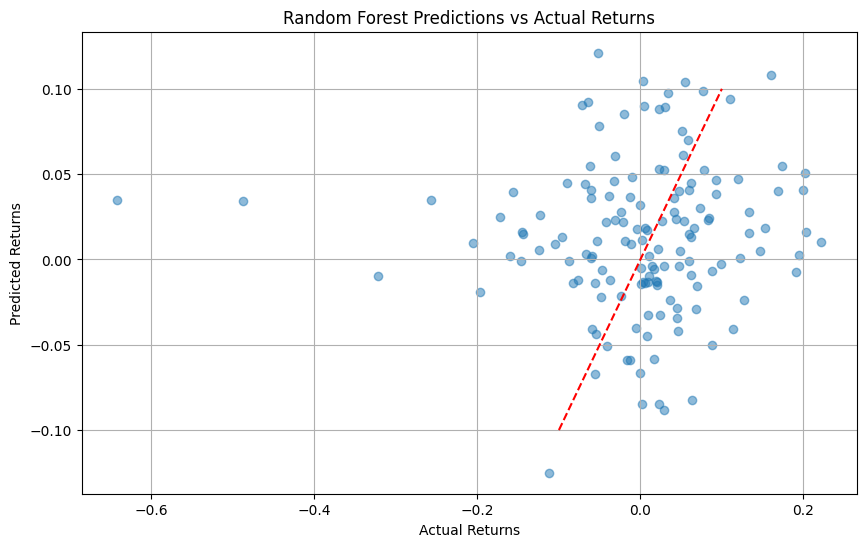

Ticker       DIS       ECL       FHN       IQV       PBA
Date                                                    
2      -0.029890  0.009280 -0.002096  0.011804  0.015272
3      -0.062394 -0.002301 -0.154904  0.012574 -0.025200
4      -0.048690 -0.015294  0.019803  0.017965  0.042595
5      -0.020563  0.012181  0.000898  0.019777  0.015545
6      -0.015675  0.004925 -0.005629  0.005918  0.007650
7      -0.005608  0.012632  0.009555  0.004046  0.010051
8      -0.018048  0.003662 -0.020808 -0.007427  0.006945
9      -0.013413  0.000248  0.001354 -0.009222  0.014222
10     -0.016071  0.005855  0.001256  0.009409  0.012189
11     -0.027546  0.014887 -0.008334  0.015643  0.008259
12     -0.022121  0.021339 -0.018378  0.016969  0.002954


<Figure size 1200x600 with 0 Axes>

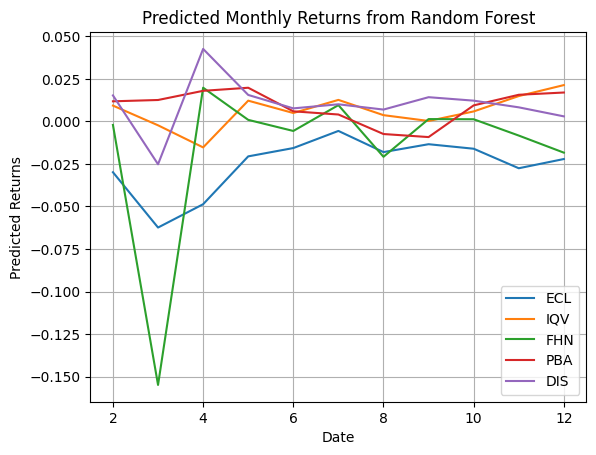

In [ ]:
#set random forest parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Prepare the data for Random Forest

stocks = ['ECL', 'IQV', 'FHN', 'PBA', 'DIS']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')['Close']
df = df.resample('M').last()
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
price_series = df

X = price_series.shift(1).dropna().values
y = log_returns.shift(-1).dropna().values

# realigning matrices
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
# Make predictions
y_pred = rf_model.predict(X_test)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
# Plot the predictions vs actual returns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Random Forest Predictions vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()
plt.show()

#get predicted pooled returns
price_series_aggregated = price_series.groupby(price_series.index.month).mean()

predicted_returns = rf_model.predict(price_series_aggregated.shift(1).dropna().values)

# Align predicted returns with the correct index and columns
predicted_returns = pd.DataFrame(predicted_returns, index=price_series_aggregated.index[1:], columns=price_series.columns)
print(predicted_returns)
plt.figure(figsize=(12, 6))
predicted_returns.plot()
plt.title('Predicted Monthly Returns from Random Forest')
plt.xlabel('Date')
plt.ylabel('Predicted Returns')
plt.legend(stocks)
plt.grid()
plt.show()


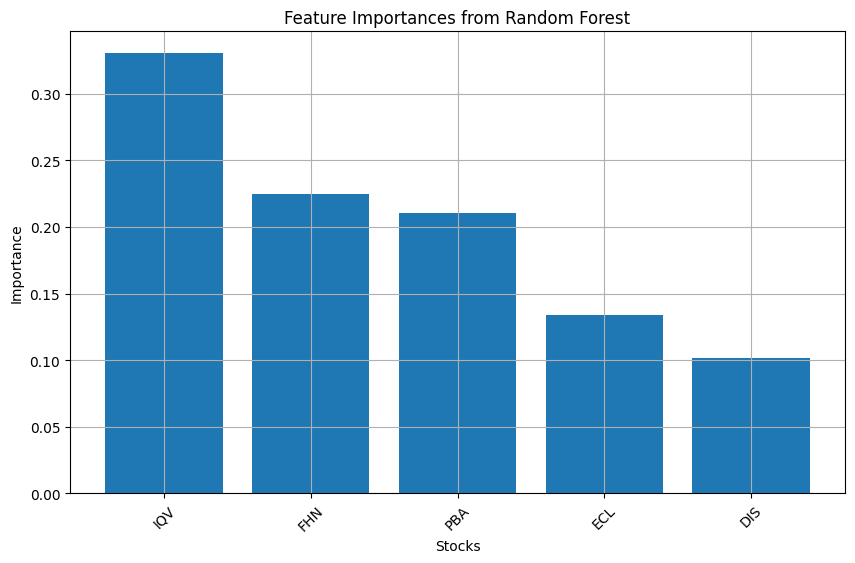

In [29]:
#plot the importance of each stock
importances = rf_model.feature_importances_
feature_names = price_series.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Stocks')
plt.ylabel('Importance')
plt.grid()
plt.show()

In [ ]:
#Set optimal portfolio weights based on the predicted returns USING MARKOVITZ
from scipy.optimize import minimize

muh = price_series.mean()
sigma = price_series.cov()
def portfolio_variance(weights, sigma):
    return np.dot(weights.T, np.dot(sigma, weights))

weights_initial = np.array([1/len(stocks)] * len(stocks))
def objective_function(weights, mu, sigma):
    return -np.dot(weights, mu) / np.sqrt(portfolio_variance(weights, sigma)) #muh*weight/sigma
def constraint_sum(weights):
    return np.sum(weights) - 1
# Constraints and bounds
constraints = {'type': 'eq', 'fun': constraint_sum}
bounds = tuple((0, 1) for _ in range(len(stocks)))
# Optimize the portfolio weights
result = minimize(objective_function, weights_initial, args=(muh, sigma), method='SLSQP', bounds=bounds, constraints=constraints) #Assign convex optimiser
optimal_weights = result.x
print(f'Optimal Weights: {optimal_weights}')
#print stock names and their corresponding weights
for stock, weight in zip(stocks, optimal_weights):
    print(f'{stock}: {weight:.4f}')

Optimal Weights: [0.08065971 0.14787608 0.54444367 0.02901424 0.1980063 ]
ECL: 0.0807
IQV: 0.1479
FHN: 0.5444
PBA: 0.0290
DIS: 0.1980


In [ ]:
#pass feedforward neural network parameters and get optimal criteria
from sklearn.neural_network import MLPRegressor

NameError: name 'claude' is not defined